# **Downloading and extracting data**

In [67]:
# import kagglehub
# path = kagglehub.dataset_download("bhaveshmittal/celebrity-face-recognition-dataset")
# print("Path to dataset files:", path)

In [68]:
# !mv /root/.cache/kagglehub/datasets/bhaveshmittal/celebrity-face-recognition-dataset/versions/1 /content/

In [69]:
# !unzip "/content/Ashok.zip"
# !unzip "/content/Priynash.zip"
# !unzip "/content/Vrajesh.zip"

In [70]:
# !mkdir "/content/final_data"

In [71]:
# !mv "/content/Ashok" "/content/final_data/Ashok"

In [72]:
# !mv "/content/Priynash" "/content/final_data/Priyansh"

In [73]:
# !mv "/content/Vrajesh" "/content/final_data/Vrajesh"

In [74]:
# !unzip "/content/Ashok.zip"
# !unzip "/content/Priynash.zip"
# !unzip "/content/Vrajesh.zip"

# !mkdir "/content/final_data"

# !mv "/content/Ashok" "/content/final_data/Ashok"
# !mv "/content/Priynash" "/content/final_data/Priyansh"
# !mv "/content/Vrajesh" "/content/final_data/Vrajesh"

In [75]:
# !pip install --upgrade tensorflow

In [76]:
# !pip show tensorflow

# **Extracting, Exploring and Preprocessing the data**

In [77]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [78]:
train_dir = '/content/final_data/'

In [79]:
train_datagen = ImageDataGenerator(
    rotation_range=20,              # Rotate images by 20 degrees
    width_shift_range=0.2,          # Shift width by 20%
    height_shift_range=0.2,         # Shift height by 20%
    horizontal_flip=True,           # Flip images horizontally
    zoom_range=0.2,                 # Zoom in/out by 20%
    brightness_range=[0.8, 1.2]     # Adjust brightness randomly
)

In [80]:
train_dataset = image_dataset_from_directory(
    train_dir,
    labels='inferred',
    image_size=(128, 128),
    batch_size=32,
    validation_split=0.2,
    subset='training',
    seed=42
)

Found 700 files belonging to 3 classes.
Using 560 files for training.


In [81]:
validation_dataset = image_dataset_from_directory(
    train_dir,
    labels='inferred',
    image_size=(128, 128),
    batch_size=32,
    validation_split=0.2,
    subset='validation',
    seed=42
)

Found 700 files belonging to 3 classes.
Using 140 files for validation.


In [82]:
class_names = train_dataset.class_names
class_names

['Ashok', 'Priyansh', 'Vrajesh']

In [83]:
for image in train_dataset:
    print(image[0].shape)
    break

(32, 128, 128, 3)


In [84]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomContrast(0.2)
])

In [85]:
def augment(image, label):
    return data_augmentation(image, training=True), label

In [86]:
def normalize(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

In [87]:
train_dataset = train_dataset.map(normalize)
validation_dataset = validation_dataset.map(normalize)

In [88]:
train_dataset = train_dataset.map(augment)
validation_dataset = validation_dataset.map(augment)

# **Building CNN Model**

## **Creating base model using MobileNet V2**

In [89]:
base_model = tf.keras.applications.ResNet50(input_shape=(128,128,3),
                                               include_top=False,
                                               weights='imagenet')

In [90]:
base_model.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 134, 134,  │          0 │ input_layer_8[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 64, 64,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 64, 64,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 64, 64,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 66, 66,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 32, 32,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 32, 32,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 32, 32,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 32, 32,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 32, 32,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 32, 32,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 32, 32,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 32, 32,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 32, 32,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 32, 32,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 32, 32,    │      1,024 │ conv2_block1_3_c

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [91]:
print(len(base_model.layers))

175


In [92]:
# Freezing the model
base_model.trainable = False
base_layer_count = len(base_model.layers)
base_model.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 134, 134,  │          0 │ input_layer_8[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 64, 64,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 64, 64,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 64, 64,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 66, 66,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 32, 32,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 32, 32,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 32, 32,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 32, 32,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 32, 32,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 32, 32,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 32, 32,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 32, 32,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 32, 32,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 32, 32,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 32, 32,    │      1,024 │ conv2_block1_3_c

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,587,712 (89.98 MB)

In [93]:
# prediction_layer = tf.keras.layers.Dense(len(class_names), activation="softmax")

## **Architecture of Model**

In [94]:
from tensorflow.keras import layers, Model

In [95]:
inputs = tf.keras.Input(shape=(128, 128, 3))
x = layers.Resizing(128, 128)(inputs)   # resizing layer
x = base_model(x, training=False)       # ensure it outputs tensor
x = layers.Flatten()(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(512, activation="relu")(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(len(class_names), activation="softmax")(x)  # replace prediction_layer

model = Model(inputs, outputs)

In [96]:
print(len(base_model.layers))
print(len(model.layers))

175
12


## **Compiling and training model**

In [97]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [98]:
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resizing_3 (Resizing)           │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 4, 4, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32768)          │       131,072 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 512)            │    16,777,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,661,123 (155.11 MB)

 Trainable params: 17,007,875 (64.88 MB)

 Non-trainable params: 23,653,248 (90.23 MB)

In [99]:
checkpoint_acc = tf.keras.callbacks.ModelCheckpoint(filepath='best_weights_acc.keras',
                                 monitor='val_accuracy',
                                 verbose=1,
                                 save_best_only=True,
                                 mode='max')

checkpoint_loss = tf.keras.callbacks.ModelCheckpoint(filepath='best_weights_loss.keras',
                                  monitor='val_loss',
                                  verbose=1,
                                  save_best_only=True,
                                  mode='min')

In [100]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_accuracy', patience=15)
history = model.fit(train_dataset, epochs=50, validation_data=validation_dataset, callbacks=[early_stopping, checkpoint_acc, checkpoint_loss])

Epoch 1/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7169 - loss: 0.6623
Epoch 1: val_accuracy improved from -inf to 0.37857, saving model to best_weights_acc.keras

Epoch 1: val_loss improved from inf to 10.07690, saving model to best_weights_loss.keras
18/18 ━━━━━━━━━━━━━━━━━━━━ 65s 3s/step - accuracy: 0.7230 - loss: 0.6497 - val_accuracy: 0.3786 - val_loss: 10.0769
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9403 - loss: 0.1968
Epoch 2: val_accuracy did not improve from 0.37857

Epoch 2: val_loss did not improve from 10.07690
18/18 ━━━━━━━━━━━━━━━━━━━━ 51s 3s/step - accuracy: 0.9400 - loss: 0.1961 - val_accuracy: 0.3786 - val_loss: 17.9585
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9638 - loss: 0.0977
Epoch 3: val_accuracy did not improve from 0.37857

Epoch 3: val_loss did not improve from 10.07690
18/18 ━━━━━━━━━━━━━━━━━━━━ 47s 3s/step - accuracy: 0.9641 - loss: 0.0968 - val_accuracy: 0.3786 - val_loss: 18.8999
Epoch 4/50
18/18 ━━━━

In [101]:
training_accuaracies = history.history['accuracy']
validation_accuaracies = history.history['val_accuracy']
training_losses = history.history['loss']
validation_losses = history.history['val_loss']

In [102]:
validate_loss, validate_accuracy = model.evaluate(validation_dataset)

5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 1.0000 - loss: 1.8620e-04


In [103]:
print(validate_accuracy)
print(validate_loss)

1.0
0.00020356409368105233


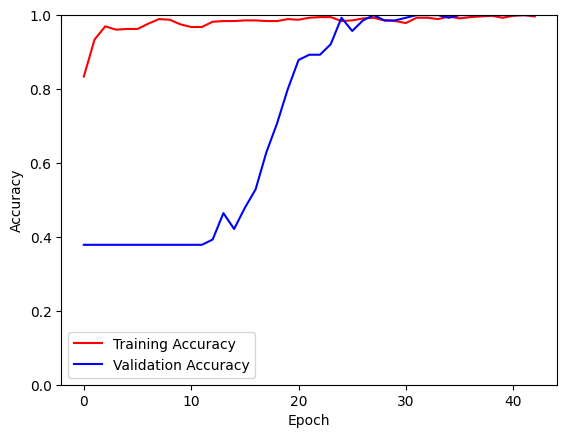

In [104]:
plt.plot(training_accuaracies, label='Training Accuracy', color='red')
plt.plot(validation_accuaracies, label='Validation Accuracy', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0,1])
plt.legend()

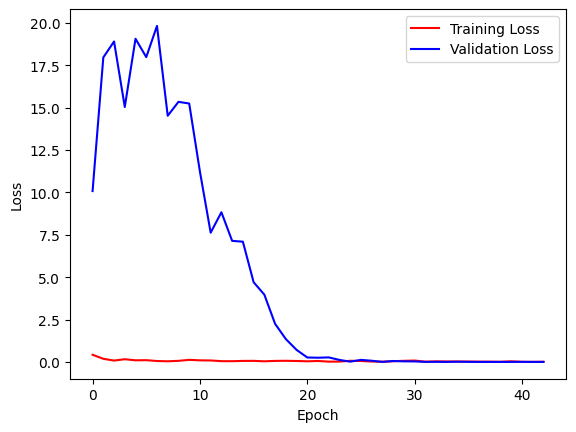

In [105]:
plt.plot(training_losses, label='Training Loss', color='red')
plt.plot(validation_losses, label='Validation Loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

In [106]:
model.save('student_recognition.keras')